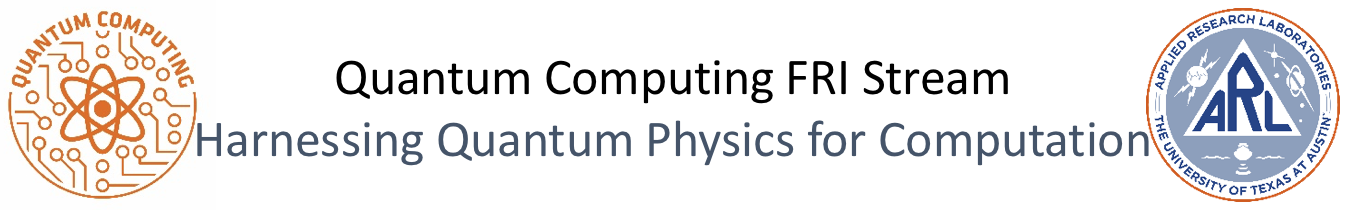

# Optimize With Grover
## Lesson 10

### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np
from qiskit.visualization import plot_histogram
import random

In [3]:
from qiskit.circuit.library import QFT

def built_in_qft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=False, inverse=False, insert_barriers=False, name='qft')
    qc.append(gate, qubits)

    return qc

def built_in_iqft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=False, inverse=True, insert_barriers=False, name='iqft')
    qc.append(gate, qubits)

    return qc

## Today's Objectives

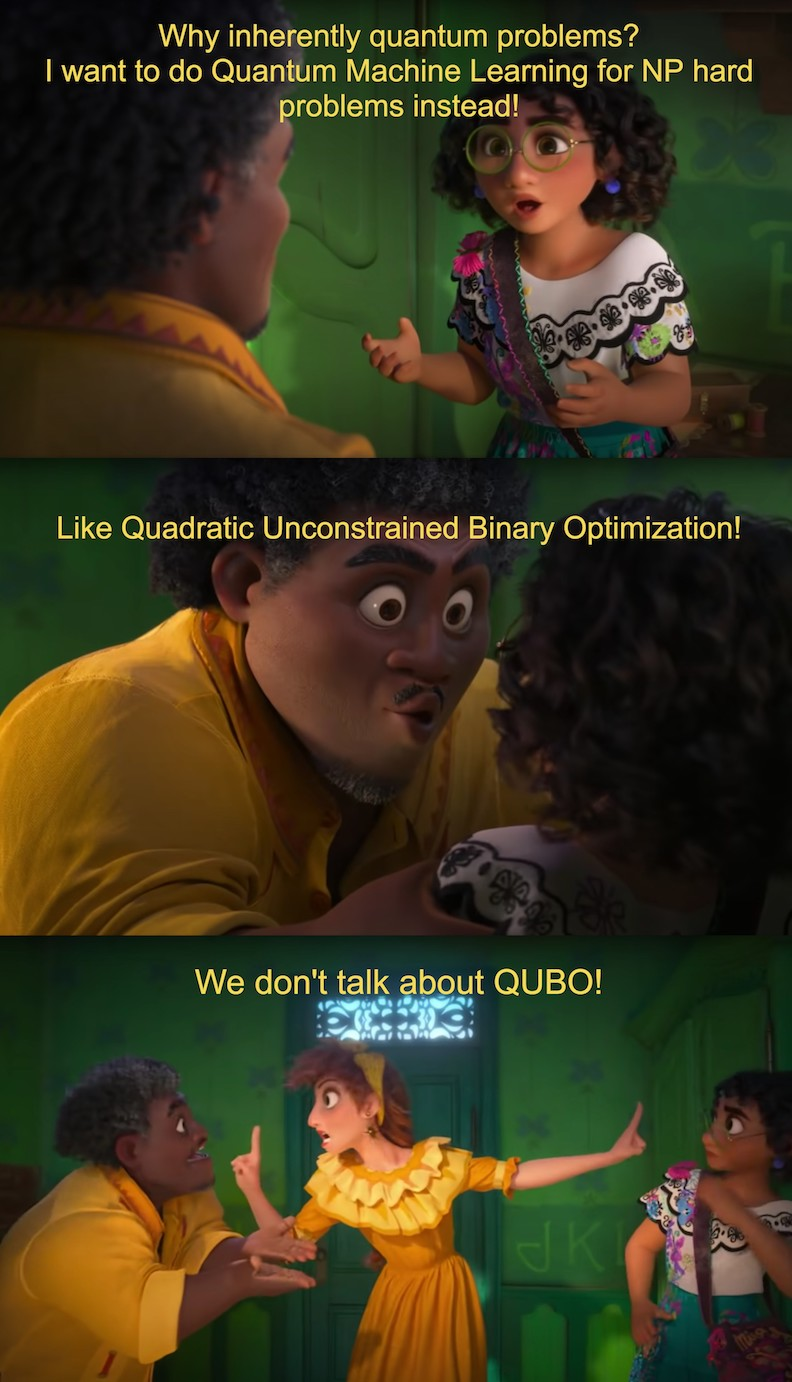

- Establish a framework for optimization problems
- Show how Grover's search algorithm can be adapted for optimization

## QUBO - Quadratic Unconstrained Binary Optimization

QUBO is a class of NP-hard problems that take the following form:

$\text{Given some }n\text{-bit binary input space }$
$$X=\{0,1\}^n$$
$\text{ find }$
$$x=\min\limits_{x \in X} \sum\limits_{i,j=0}^{2^n -1} q_{ij}x_{i}x_{j}$$

In other words, we want to find the bitstring $x$ for which the cost function $f(x)=\sum\limits_{i,j=0}^{2^n -1} q_{ij}x_{i}x_{j}$ is minimized.

<font color=blue> The list of coupling coefficients $q_{ij}$ fully characterizes the problem up to a constant. </font>

QUBO problems are found across disciplines including molecular energy calculations and portfolio optimization.

### <font color=green> Exercise 1 </font>

Write a Python script to find the minimum bitstring $x^*$ for  $$f(x)=-2x_{0}x_{2}-x_{1}x_{2}-x_{0}+2x_{1}-3x_{2}$$

101 is answer i think

In [33]:
x0, x1, x2 = random.randint(0,1), random.randint(0,1), random.randint(0,1)
print(x0, x1, x2)

function = -2*x0*x2 - x1*x2 - x0 + 2*x1 - 3*x2
print(function)

1 1 1
-5


## Grover Adaptive Search

We all remember how Grover's search algorithm works.

#### <font color=blue> Refresher </font>

$1) \text{ Start with an }n\text{-qubit input and 1-qubit output register.}$
$$|0\dots 0\rangle|0\rangle$$

$2) \text{ Apply a NOT and then Hadamard to the output register.}$

$3) \text{ Apply Hadamards to the input register.}$

$4) \text{ Do the following }R\text{ times, where }R=\lfloor\pi\sqrt{N/M}/4\rfloor$

$\quad \text{a) Apply the oracle }\mathbf{U}_{f}$

$\quad \text{b) Apply }\mathbf{W}=-\prod_{i=1}^{n}\mathbf{H}_{i}\mathbf{X}_{i} \;\; \mathbf{C}^{\mathbf{Z}}_{n\dots 2 1}\;\prod_{j=1}^{n}\mathbf{X}_{j}\mathbf{H}_{j}\text{ to the input register}$

$5) \text{ Apply a Hadamard and then NOT gate to the output register.}$

$6) \text{ Measure the input register; the result is most likely one of } a_{1},\dots,a_{M}.$

### Grover's search algorithm can be used to solve QUBO problems in the following way:

$1) \text{ Build an oracle that calculates the cost function }f(x)$

$2) \text{ Choose a threshold }y$

$3) \text{ Build an oracle that compares your cost function to your threshold }$

$4) \text{ Use Grover's algorithm to find an input }x \text{ such that }f(x)<y$

$5) \text{ Set }y^\prime=f(x)$

$6) \text{ Repeat }3-5 \text{ until some desired end condition is met}$




## Oracle Building

Also known as "the hard part"

### Quantum Dictionaries

Introduced formally in https://arxiv.org/abs/1907.11513 a quantum dictionary builds on the programming idea of a dictionary in which each key in the key register corresponds to a particular value in the value register.

<font color=blue> Dictionary entries are NOT ordered. </font>

In [ ]:
# Example Dictionary
newDictionary = {'banana':'phone','up':'down','truck':'wheel'}

In [ ]:
newDictionary['banana']

We want to build an operator $\mathbf{A}$ that creates a quantum dictionary such that

$\mathbf{A}\lvert{0}\rangle_{n}\lvert{0}\rangle_{m} = \frac{1}{\sqrt{2^n}} \sum\limits_{x=0}^{2^n-1}\lvert x\rangle_{n}\lvert f(x)\rangle_{m}$

As a first step, we can encode a value into the phase of a superposition state and then use a QFT to encode that phase as the state vector.

The phase encoding can be accomplished by an operator we call $U_g$

$$\mathbf{U}_g(\theta)\;\mathbf{H}^{\otimes m}\lvert 0 \rangle_{m} = \frac{1}{\sqrt{2^m}} \sum\limits_{k=0}^{2^m-1}e^{ik\theta}\lvert k\rangle_{m} $$

For $\theta = \frac{2\pi}{2^m}k$ we get

$$\mathbf{QFT}^{\dagger}\mathbf{U}_g(\theta)\;\mathbf{H}^{\otimes m}\lvert 0 \rangle_{m} =\lvert k\mod 2^m \rangle_{m}$$

### <font color=green> Exercise 2 </font>

Complete the function Ug in order to apply the appropriate rotations to our superposition state.

<font color=blue> Hint: Phase rotation is another way of saying Z rotation. Each qubit's rotation should depend on both the angle $\theta$ and also on the qubit index. </font>

<font color=dark blue> Super Hint: Qubit $i$ should be rotated by $2^{m-1-i}\theta$ </font>

In [34]:
def Ug(qc,qout,theta):
  m=qout.size

  for i in range(m):
    qc.p(2**(m - 1 - i) * theta, qout[i])
  # TODO
  #~~~~

In [43]:
m=3
q=QuantumRegister(m)
c=ClassicalRegister(m)
qc=QuantumCircuit(q,c)

qc.h(qc.qubits)

k=8 #the number to encode

Ug(qc,q,2*np.pi/2**m*k)

built_in_iqft(qc,q,m)

qc.measure(q,c)

qc.draw()

┌───┐┌───────┐┌───────┐┌─┐      
q19_0: ┤ H ├┤ P(8π) ├┤0      ├┤M├──────
       ├───┤├───────┤│       │└╥┘┌─┐   
q19_1: ┤ H ├┤ P(4π) ├┤1 iqft ├─╫─┤M├───
       ├───┤├───────┤│       │ ║ └╥┘┌─┐
q19_2: ┤ H ├┤ P(2π) ├┤2      ├─╫──╫─┤M├
       └───┘└───────┘└───────┘ ║  ║ └╥┘
 c3: 3/════════════════════════╩══╩══╩═
                               0  1  2

{'000': 1024}


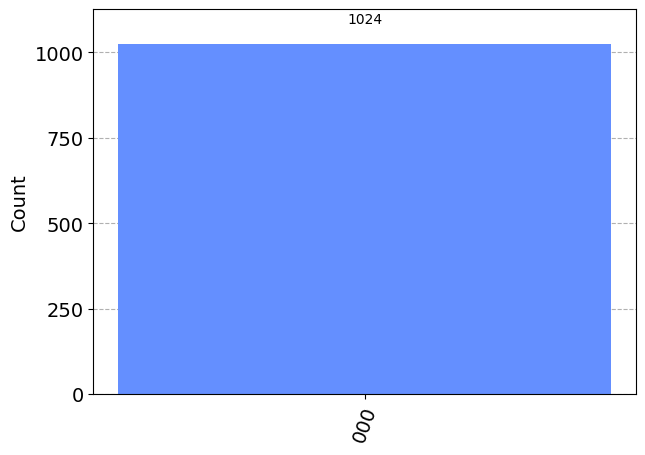

In [44]:
counts = execute(qc, backend = Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
print(counts)
plot_histogram(counts)

### Full Dictionaries

The following functions build on the unitary operator we made in the previous exercise by adding control qubits.

We want the number encoded by our unitary to correspond to the cost function $f(x)$ and to be entangled with the corresponding input $x$.

So, the encoded number for each rotation is the weight $q_{ij}$ given in our problem specification while the controlling qubits are given by the associated $x_{i}$ and $x_{j}$.



In [45]:
# This function implements separable Z rotations of multiples of "theta"
def Ug(qc,qout,theta):
  m=qout.size

  for i in range(m):
    lam=2**(m-1-i)*theta
    qc.p(lam,qout[i])

In [46]:
# This function returns a Cgate of separable U1 rotations on "targets"
# 1 control qubit in "control"
def cUg(qc,control,qin,targets,theta):
  m=len(targets)
  qt=QuantumCircuit(targets)
  for i in range(m):
    lam=2**(m-1-i)*theta
    qt.p(lam,i)
  bigU1 = qt.to_gate().control(1)

  qubitlist = [qin[control]]
  for i in range(m):
    qubitlist.append(targets[i])
  qc.append(bigU1,qubitlist)

  return qc

In [47]:
# This function returns a CCgate of separable U1 rotations on "targets"
# 2 control qubits in "controls"
def ccUg(qc,controls,qin,targets,theta):
  m=len(targets)
  qt=QuantumCircuit(targets)
  for i in range(m):
    lam=2**(m-1-i)*theta
    qt.p(lam,i)
  bigU1 = qt.to_gate().control(2)

  qubitlist = [qin[controls[0]],qin[controls[1]]]
  for i in range(m):
    qubitlist.append(targets[i])
  qc.append(bigU1,qubitlist)

  return qc

In [48]:
# This function combines the three unitaries from above into the full quantum dictionary
# It applies the unitaries appropriate to the problem specified in "controlList" and "coefficients"
def AOperator(qc,qin,qout,controlList,coefficients):
#takes |0>|0> to SumOverx |x>|f(x)>
  m = len(qout)
  qc.h(qout)

  for i in range(len(controlList)):
    if len(controlList[i])==2:
      theta = (2*np.pi/2**m)*coefficients[i]
      ccUg(qc,controlList[i],qin,qout,theta)
    if len(controlList[i])==1:
      theta = (2*np.pi/2**m)*coefficients[i]
      cUg(qc,controlList[i],qin,qout,theta)
    if len(controlList[i])==0:
      theta = (2*np.pi/2**m)*coefficients[i]
      Ug(qc,qout,-theta)  #negative theta! as the threshold. This is mentioned in the next section.

  #iQFT swaps=False
  built_in_iqft(qc,qout,m)

### The Oracle Itself

In order to compare values, we really want to incorporate the threshold into our state.

$$\mathbf{A}\lvert{0}\rangle_{n}\lvert{0}\rangle_{m} = \frac{1}{\sqrt{2^n}} \sum\limits_{x=0}^{2^n-1}\lvert x\rangle_{n}\lvert f(x)-y\rangle_{m}$$

Now we need an oracle that recognizes $f(x)<y$ or equivalently $f(x)-y<0$

Recall that, in Grover's algorithm, we want our oracle to rotate the state only when the function is satisfied.

We can accomplish this with:

- Two's complement (most significant output qubit holds the sign bit)
- Z gate

$$\mathbf{U} = \mathbf{Z}_{m-1}$$

The two's complement method of handling negative numbers means that the most significant bit will only be $\texttt{1}$ when the function value is less than the chosen threshold.

And the $\mathbf{Z}$ gate only applies a phase to bits in the $\texttt{1}$ state!

The oracle described above marks any inputs for which $f(x)-y<0$

### Diffusion Operator

We are almost ready. Now we need to apply our gates in the appropriate order. In order for the normal diffusion operator $\mathbf{W}$ to work, we must condition the state by first using $\mathbf{A}^{\dagger}$, then applying $\mathbf{W}$, and finally recondition the state with $\mathbf{A}.$

More succinctly, we replace the usual diffusion operator with
$$ \mathbf{W}^{\prime}=\mathbf{A}\mathbf{W}\mathbf{A}^{\dagger}$$

## Putting it All Together: Grover Adaptive Search with Phase Encoding

The only thing we need now is to choose a proper threshold and apply the algorithm!

Implementation based on this paper by Gilliam, Woerner, and Gonciulea

https://arxiv.org/abs/1912.04088v3 now published in Quantum 5, 428 (2021)

In [49]:
# This function is the inverse of our quantum dictionary function, AOperator
def AOpdagger(qc,qin,qout,controlList,coefficients):
#takes SumOverX |x>|f(x)> to |0>|0>
  m = len(qout)

  #QFT swaps=False
  built_in_qft(qc,qout,m)

  for i in reversed(range(len(controlList))):
    if len(controlList[i])==2:
      theta = (-2*np.pi/2**m)*coefficients[i]
      ccUg(qc,controlList[i],qin,qout,theta)
    if len(controlList[i])==1:
      theta = (-2*np.pi/2**m)*coefficients[i]
      cUg(qc,controlList[i],qin,qout,theta)
    if len(controlList[i])==0:
      theta = (-2*np.pi/2**m)*coefficients[i]
      Ug(qc,qout,-theta)  #negative theta! as the threshold

  qc.h(qout)


In [50]:
# This function implements a multi-controlled-Z gate on "qubits"
# It can be replaced by the more general, built-in gate qc.mcp(np.pi,q_(controls),q_(target))
def CCnZ(qc,qubits):
  n=len(qubits)

  qt=QuantumCircuit(2)
  qt.cz(0,1)

  bigCZ=qt.to_gate(label='CZ').control(n-2)

  qc.append(bigCZ,qubits)

  return qc

In [51]:
def Grover1(xlist,couplings,y,r): #xlist is the list of interactions, couplings is the strength of the interactions, y is the threshold
# Set up the circuit
# The input space is defined by the problem (number of x bits)
# The output space should be large enough to hold the maximum possible score plus one sign bit which acts as the flag for our oracle
  n=3
  m=4
  qi=QuantumRegister(n,name='input')
  qo=QuantumRegister(m,name='output')
  c=ClassicalRegister(m)
  d=ClassicalRegister(n)
  qc=QuantumCircuit(qi,qo,c,d)

# Set the input register to the uniform superposition
  qc.h(qi)

#Define the problem
  print('y=',y)
  coeffs=couplings.copy()
  coeffs.append(y)

# Condition the space (build the quantum dictionary)
  AOperator(qc,qi,qo,xlist,coeffs)
  qc.barrier()


# Grover Iterator

  for i in range(r):
  # U Operator
    qc.z(qo[m-1])
    qc.barrier()

  #Diffusion Operator = A W Adagger
    AOpdagger(qc,qi,qo,xlist,coeffs)

    qc.barrier()
    qc.h(qi)
    qc.x(qi)
    #CCnZ(qc,qi)
    qc.mcp(np.pi,qi[1:],qi[0])
    qc.x(qi)
    qc.h(qi)
    qc.barrier()

    AOperator(qc,qi,qo,xlist,coeffs)

    qc.barrier()

  qc.measure(qo,c)
  qc.measure(qi,d)

  counts = execute(qc, backend = Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)

  return counts

Let's run our function once and see how the output looks!

$$f(x)=-2x_{0}x_{2}-x_{1}x_{2}-x_{0}+2x_{1}-3x_{2}$$

In [52]:
# Define The Problem
xlist=[[0,2],[1,2],[0],[1],[2],[]]
couplings=[-2,-1,-1,2,-3]

In [ ]:
counts=Grover1(xlist,couplings,y=-5,r=1)

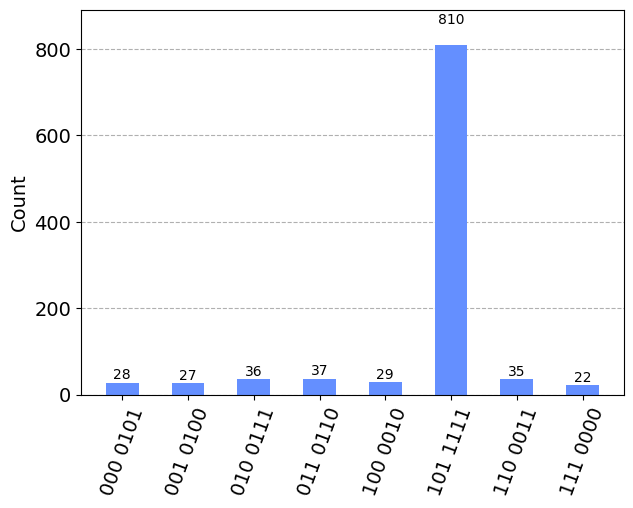

In [54]:
plot_histogram(counts)

In [55]:
x=max(counts, key=lambda key: counts[key])
print(x)

101 1111


In [56]:
fx=-2*int(x[0])*int(x[2])-int(x[1])*int(x[2])-int(x[0])+2*int(x[1])-3*int(x[2])
print(fx)

-6


We can now use Grover's search to return an assignment with a cost function less than the current threshold. This can be used as the evaluator in your favorite optimization function.

In [57]:
#This cell included as a simple example of using our function to find the solution iteratively.
maxiter=10  #We don't want to let it run forever!
score=sum(abs(value) for value in couplings) #The largest possible score even ignoring the couplings
y=-score  #initial threshold
bestx=0   #Zero is the simplest uninformed guess
r=1       #number of Grover iterations. Let's limit it for now.
cutoff = -5   #This will depend on the problem setup

for i in range(maxiter):
  print('r=',r)
  counts=Grover1(xlist,couplings,y,r) #Run the search with the current threshold

  x=max(counts, key=lambda key: counts[key])  #Pick the highest probability outcome
  print('x = ',x)
  fx=-2*int(x[0])*int(x[2])-int(x[1])*int(x[2])-int(x[0])+2*int(x[1])-3*int(x[2]) #Evaluate the function with the chosen outcome
  print('f(x) =',fx)
  if fx<score:    #Is the function value better than the best so far?
    r=1           #If so, update the variables
    y+=1
    score=fx
    bestx=x
    if score<cutoff:
      break
  else:
    if r<3:       #If the value isn't better, try again with a new number of iterations
      r+=1
    else:         #Or just move on
      r=1
      y+=1
print('best x=',bestx,' with a score of ',score)

r= 1
y= -9
x =  101 0011
f(x) = -6
best x= 101 0011  with a score of  -6


## Thanks Qiskit Community

This algorithm has been built into a canned function for optimization.

<font color=red> Unfortunately, the dependencies have since moved. The cells below contain a version that once worked. Track down the correct imports if you wish to make it work again.

Code here
https://github.com/Qiskit/qiskit-optimization/blob/main/qiskit_optimization/algorithms/grover_optimizer.py

Tutorial here
https://github.com/Qiskit/qiskit-optimization/blob/main/docs/tutorials/04_grover_optimizer.ipynb


In [65]:
#from qiskit.aqua.algorithms import NumPyMinimumEigensolver
#from qiskit.optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer
#from qiskit.optimization.problems import QuadraticProgram
from qiskit import BasicAer
from docplex.mp.model import Model

backend = BasicAer.get_backend('statevector_simulator')

ModuleNotFoundError: ignored

In [64]:
model = Model()
x0 = model.binary_var(name='x0')
x1 = model.binary_var(name='x1')
x2 = model.binary_var(name='x2')
model.minimize(-x0+2*x1-3*x2-2*x0*x2-1*x1*x2)
qp = QuadraticProgram()
qp.from_docplex(model)
print(qp.export_as_lp_string())

NameError: ignored

In [66]:
grover_optimizer = GroverOptimizer(6, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print("x={}".format(results.x))
print("fval={}".format(results.fval))

NameError: ignored